In [1]:
import pandas as pd
import json
import re
import tifffile as tiff
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from tqdm import tqdm

from sklearn.linear_model import LinearRegression


import cv2


## Get some frames

In [2]:
with tiff.TiffFile('4-2.tif') as tif:
    frames = tif.asarray()

f = []

for i in tqdm(range(len(frames))):
    f.append(frames[i][:, :, 0])

100%|██████████| 100/100 [00:00<?, ?it/s]


## BG subtraction (for test, I will take a simple one)

In [3]:
def medianInit(frames:np.array)->np.array:
    """ 
    Function to initialize the background from the first frames

    Args:
    -----
    - `frames`: starting frames
    """
    bg = None

    for f in frames:
        if bg is None:
            bg = f.reshape(1, *f.shape)

        else:
            bg = np.vstack((bg, f.reshape(1, *f.shape)))

    return np.median(bg, axis=0).astype(int)





class background_sub():
    def __init__(self, frames, params):
        self.frames = frames

        self.alpha = params[0]                  # exponential filter

        self.threshold = params[1]              # threshold comparison

        self.nbIinit = params[2]                # number of frames to wait for the bg init

        self.initFrameId = params[2]-1           # id of the first frame

        self.methodUpdate = params[3]           # 0  if alpha is constnat, 1 for decreasing alpha

        self.nbFrames = 0                       # number of frames for the decreasing alpha

        self.binMaps = []                       # list of binary maps

        self.initVersion = params[4]            # 0: model, 1: median
        
    def _initBg(self, frames: list)->np.array:
        """ 
        Initialization of the algorithm

        Args:
        -----
        - `frames`: list of frames from which the init background is obtained
        """
        
        if self.initVersion == 0:
            bg = initialBackgroundv2(frames[0])     
        elif self.initVersion == 1:
            bg = medianInit(frames[:self.nbIinit])

        return bg

    def _updateBg(self, prevBg:np.array, frame:np.array, alpha:float, bMap:np.array)->np.array:
        """ 
        Function to perform the update

        Args:
        -----
        -`prevBg`: previous background
        - `frame`: current frame
        - `alpha`: learning rate
        - `bMap`: binary map from background subtraction (not used)
        """
        return ((1-alpha) * prevBg + alpha * frame)

    
    def _compareFrames(self, frame:np.array, bg:np.array, threshold:float)->np.array:
        """  
        Function to compare the background and the foreground

        Args:
        -----
        - `frame`: foreground
        - `bg`: background
        - `threshold`: threshold in the comparison

        Returns:
        --------
        The binary map
        """

        d = np.abs(bg - frame)

        bMap = (d >= threshold)
        return bMap


    def _loop(self):
        """ 
        Main function to apply the background subtraction algorithm
        """

        ## initialize the background
        bg = self._initBg(self.frames)

        for i in range(self.initFrameId, len(self.frames)):

            ## compare background and foreground
            bMap = self._compareFrames(self.frames[i], bg, self.threshold)
            
            self.binMaps.append(bMap)

            ## get the current alpha
            if self.methodUpdate:
                alpha = self.alpha / (self.nbFrames+1)
                self.nbFrames += 1
            else:
                alpha = self.alpha

            # update the background
            bg = self._updateBg(bg, self.frames[i], self.alpha, bMap)

            bg = bg.astype(int)
        return self.binMaps
    

bgS2 = background_sub(f, [0.10, 60, 6, 1, 1])

bMap = bgS2._loop()

## Ideas of pipeline

# IDEA 1

0) background subtraction (not necessary, not sure)
1) closing (deal with noise) (unecessary I think if the dilation is big enough afterwards)
2) dilate (upper bound on the estimate)
3) edge detection (Canny, Sobel or other)
4) detect shape (Circle transform, ...)
5) bounding box 

# Need to check if generalizes well when used with other images

In [5]:
def pipe1(image):
    ## Bsub done before
    
    ## closing

    radius = 25  # to change
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    im2 = cv2.morphologyEx(image,  
                            cv2.MORPH_CLOSE, 
                            kernel, 
                            iterations=1)


    ## dilate

    radius = 10  # to change
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))

    im3 = cv2.dilate(im2, kernel, iterations=1) 


    ## edge detection

    threshold = 2

    canny_output = cv2.Canny(im3, threshold, threshold * 2)

    ## hough circle transform

    circles = cv2.HoughCircles(canny_output, cv2.HOUGH_GRADIENT, 1.3, 500, param1=120, param2=45, minRadius=250, maxRadius=400)

    return circles

In [8]:
bList = []
fList = []
cList = []

for i in tqdm(range(len(bMap))):
    bg = bMap[i].astype(np.uint8)
    im = f[i+5]

    c = pipe1(bg)

    bList.append(bg)
    fList.append(np.tile(im[:, :, np.newaxis], (1,1,3)))
    cList.append(c)




100%|██████████| 95/95 [00:21<00:00,  4.32it/s]


In [ ]:
import matplotlib.animation as mat_anim
from IPython.display import HTML

def draw_frames(frames, bList, circles_list):
    if len(frames) != len(circles_list):
        raise Exception("The number of frames on each array doesn't match.")
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    plt.tight_layout()

    def update(frame):
        plt.suptitle(f"Frame {frame}")
        axs[0].clear() 
        axs[1].clear()  
        axs[2].clear()  
        axs[0].set_title("Original")
        axs[0].imshow(frames[frame], cmap='gray')  

        axs[1].imshow(bList[frame], cmap='gray') 

        f2 = np.copy(frames[frame])

        for c in circles_list[frame][0, :]:
            c = c.astype(int)
            cv2.circle(f2, (c[0], c[1]), c[2], (0, 255, 0), 3)
            # Draw the center of the circle
            cv2.circle(f2, (c[0], c[1]), 1, (0, 0, 255), 5)

        axs[2].imshow(cv2.cvtColor(f2, cv2.COLOR_BGR2RGB))
        axs[2].set_title("Circles")
        return axs

    return mat_anim.FuncAnimation(fig=fig, func=update, frames=len(frames), interval=500)


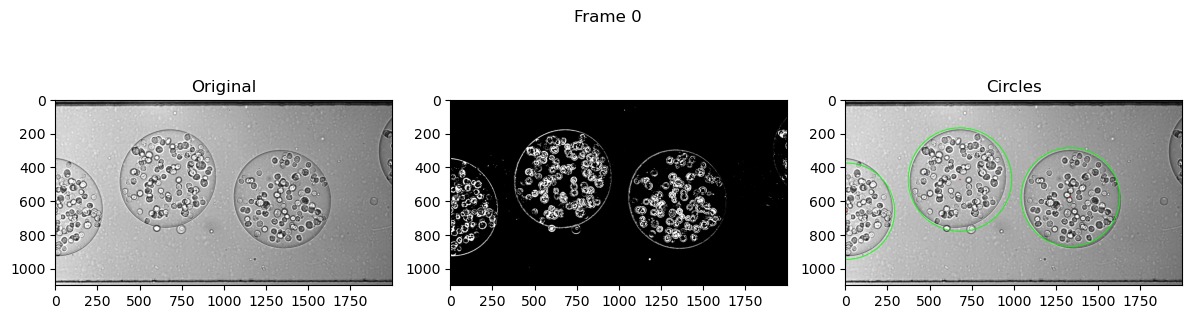

In [9]:
animation = draw_frames(fList, bList, cList)
HTML(animation.to_html5_video())

## Idea 2

0) background subtraction (not necessary I think)
1) closing (deal with noise)
2) dilate (upper bound on the estimate)
3) edge detection (Canny, Sobel or other)
4) detect shape (Circle transform, ...)
5) bounding box 

## Idea 3

It might be possibe to play with the edge pictures directly actually and some morphological operations